# import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NU M_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"
import numpy as np
import tqdm
import time

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from advertorch.attacks import GradientSignAttack
from torch.utils.tensorboard import SummaryWriter

from functools import reduce 


In [3]:
import sys
sys.path.append("../src/")

from datasetManager import DatasetManager
from generators import Generator
import signal_augmentations as sa 

# Utils

## Metrics

In [4]:
class Metrics:
    def __init__(self, epsilon=1e-10):
        self.value = 0
        self.accumulate_value = 0
        self.count = 0
        self.epsilon = epsilon
        
    def reset(self):
        self.accumulate_value = 0
        self.count = 0
        
    def __call__(self):
        self.count += 1

        
class BinaryAccuracy(Metrics):
    def __init__(self, epsilon=1e-10):
        Metrics.__init__(self, epsilon)
        
    def __call__(self, y_pred, y_true):
        super().__call__()
        
        with torch.set_grad_enabled(False):
            y_pred = (y_pred>0.5).float()
            correct = (y_pred == y_true).float().sum()
            self.value = correct/ (y_true.shape[0] * y_true.shape[1])
            
            self.accumulate_value += self.value
            return self.accumulate_value / self.count
        
        
class CategoricalAccuracy(Metrics):
    def __init__(self, epsilon=1e-10):
        Metrics.__init__(self, epsilon)
        
    def __call__(self, y_pred, y_true):
        super().__call__()
        
        with torch.set_grad_enabled(False):
            self.value = torch.mean((y_true == y_pred).float())
            self.accumulate_value += self.value

            return self.accumulate_value / self.count

        
class Ratio(Metrics):
    def __init__(self, epsilon=1e-10):
        Metrics.__init__(self, epsilon)
        
    def __call__(self, y_pred, y_adv_pred):
        super().__call__()
        
        results = zip(y_pred, y_adv_pred)
        results_bool = [int(r[0] != r[1]) for r in results]
        self.value = sum(results_bool) / len(results_bool) * 100
        self.accumulate_value += self.value
        
        return self.accumulate_value / self.count

In [5]:
import datetime
def get_datetime():
    now = datetime.datetime.now()
    return str(now)[:10] + "_" + str(now)[11:-7]

# Initialization

## set seeds

In [6]:
def reset_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
reset_seed()

## Prepare GPU

In [7]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
# cudnn.benchmark = True

# Model definition

## CNN original
https://arxiv.org/pdf/1608.04363.pdf

In [8]:
class ConvPoolReLU(nn.Sequential):
    def __init__(self, in_size, out_size, kernel_size, stride, padding,
                pool_kernel_size, pool_stride):
        super(ConvPoolReLU, self).__init__(
            nn.Conv2d(in_size, out_size, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride),
            nn.BatchNorm2d(out_size),
            nn.ReLU6(inplace=True),
        )
        
class ConvReLU(nn.Sequential):
    def __init__(self, in_size, out_size, kernel_size, stride, padding):
        super(ConvReLU, self).__init__(
            nn.Conv2d(in_size, out_size, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU6(inplace=True),
        )

In [9]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        
        self.features = nn.Sequential(
            ConvPoolReLU(1, 24, 3, 1, 1, (4,2), (4,2)),
            ConvPoolReLU(24, 48, 3, 1, 1, (4,2), (4,2)),
            ConvPoolReLU(48, 48, 3, 1, 1, (4,2), (4,2)),
            ConvReLU(48, 48, 3, 1, 1),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(1008, 10),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(64, 10),
        )
                
        
    def forward(self, x):
        x = x.view(-1, 1, *x.shape[1:])

        x = self.features(x)
        x = self.classifier(x)
        
        return x

## CNN 2

In [153]:
class cnn2(nn.Module):
    def __init__(self):
        super(cnn2, self).__init__()
        
        self.features = nn.Sequential(
            ConvPoolReLU(1, 24, 5, 1, 1, (4,2), (4,2)),
            ConvPoolReLU(24, 48, 5, 1, 1, (4,2), (4,2)),
            ConvReLU(48, 48, 5, 1, 1),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(1872, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
                
        
    def forward(self, x):
        x = x.view(-1, 1, *x.shape[1:])

        x = self.features(x)
        x = self.classifier(x)
        
        return x

## RNN

In [34]:
class ConvBNReLU(nn.Sequential):
    def __init__(self, in_size, out_size, conv_kernel_size, conv_stride, conv_padding):
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_size, out_size, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding),
            nn.BatchNorm2d(out_size),
            nn.ReLU(inplace=True),
        )

In [88]:
class crnn(nn.Module):
    def __init__(self):
        super(crnn, self).__init__()
        
        self.features = nn.Sequential(
            ConvBNReLU(1, 64, 3, 1, 1),
            nn.MaxPool2d(kernel_size=(4,2), stride=(4,2)),
            ConvBNReLU(64, 64, 3, 1, 1),
            nn.MaxPool2d(kernel_size=(4,2), stride=(4,2)),
            ConvBNReLU(64, 64, 3, 1, 1),
            nn.MaxPool2d(kernel_size=(4,1), stride=(4,1)),
        )
        
        self.rnn = nn.GRU(64, 64, num_layers=1, batch_first=True, bidirectional=True)

        self.strong = nn.Sequential(
            nn.Linear(128, 10),
        )
                
        
    def forward(self, x):
        x = x.view(-1, 1, *x.shape[1:])

        x = self.features(x)
        
        x = x.squeeze(dim=-2)
        x = x.permute(0, 2, 1)
        
        x, h = self.rnn(x)
        
        strong = self.strong(x)
        
        weak = strong.permute(0, 2, 1)
        weak = F.avg_pool1d(weak, kernel_size=weak.size()[2:])
#         max_pool2d(x, kernel_size=x.size()[2:])
        weak = weak.view(-1, weak.shape[1])
        
        
        return weak

## EfficientNet

In [42]:
class MultisampleDropout2d(nn.Module):
    """https://arxiv.org/pdf/1905.09788.pdf"""
    def __init__(self, ratio, nb_sample):
        super(MultisampleDropout2d, self).__init__()
        self.nb_sample = nb_sample
        
        self.dropouts = [nn.Dropout2d(ratio) for _ in range(nb_sample)]
        
    def forward(self, x):
        d = [dropout(x) for dropout in self.dropouts]
        return torch.mean(torch.stack(d, dim=0), dim=0)
    
class MultisampleDropout1d(nn.Module):
    """https://arxiv.org/pdf/1905.09788.pdf"""
    def __init__(self, ratio, nb_sample):
        super(MultisampleDropout1d, self).__init__()
        self.nb_sample = nb_sample
        
        self.dropouts = [nn.Dropout(ratio) for _ in range(nb_sample)]
        
    def forward(self, x):
        d = [dropout(x) for dropout in self.dropouts]
        return torch.mean(torch.stack(d, dim=0), dim=0)

In [26]:
class MBConv(nn.Module):
    def __init__(self, in_size, out_size, t, kernel_size, stride, padding):
        super(MBConv, self).__init__()
        expand_dim = in_size * t
        self.stride = stride

        self.conv = nn.Sequential(
            nn.Conv2d(in_size, expand_dim, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(expand_dim),
            nn.ReLU6(inplace=True),

            nn.Conv2d(expand_dim, expand_dim, kernel_size=kernel_size, stride=stride, padding=padding, groups=expand_dim),
            nn.BatchNorm2d(expand_dim),
            nn.ReLU6(inplace=True),

            nn.Conv2d(expand_dim, out_size, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_size),
            nn.ReLU6(inplace=True),
        )
    
    def forward(self, x):
        if self.stride == 1:
            return x + self.conv(x)
        return self.conv(x)

In [30]:
class EfficientNet(nn.Module):
    def __init__(self,
                 conv_input_dim: tuple = (64, 431),
                 conv_in_size: list = [1, 64, 64],
                 conv_out_size: list = [64, 64, 64],
                 t = [1, 6, 6],
                 s = [1, 2, 2],
                 n = [1, 2, 2],
                ):
        super(EfficientNet, self).__init__()
        self.i =0
        
        self.conv_input_dim = conv_input_dim
        self.conv_in_size = conv_in_size
        self.conv_out_size = conv_out_size
        self.t = t
        
        conv_layers = []
        for i in range(len(conv_in_size)):
            if i == 0:
                conv_layers.append(nn.Conv2d(conv_in_size[i], conv_out_size[i], 3, 1, 1))
                continue
            
            conv_layers.append( MBConv(conv_in_size[i], conv_out_size[i], t[i], 3, s[i], 1) )
            for j in range(n[i]-1):
                conv_layers.append( MBConv(conv_out_size[i], conv_out_size[i], t[i], 3, 1, 1) )
    
        self.features = nn.Sequential(*conv_layers)

        self.classifier = nn.Sequential(
            MultisampleDropout2d(0.2, 8),
            nn.Conv2d(self.conv_out_size[-1], 10, kernel_size=1, stride=1, padding=0),
#             nn.AdaptiveMaxPool2d((1, 1)),
        )
        
        
    def forward(self, x):
        x = x.view(-1, 1, *x.shape[1:])
#         x = x.view(-1, 1, self.conv_input_dim[0], self.conv_input_dim[1])

        x = self.features(x)
        x = self.classifier(x)
        
        x = F.avg_pool2d(x, kernel_size=x.size()[2:])
        x= x.view(-1, x.shape[1])
        
        return x


# ======== Training ========

## Prep model

In [154]:
torch.cuda.empty_cache()

# Efficient net
# model_func = EfficientNet
# m1 = EfficientNet(
#     conv_in_size= [1, 8, 16, 24, 40],
#     conv_out_size= [8, 16, 24, 40, 40],
#     t = [1, 6, 6, 4, 6, 6],
#     s = [1, 2, 2, 2, 2, 1],
#     n = [1, 3, 3, 1, 1, 1]
# )

# cnn
# m1 = cnn()µ

# rnn
model_func = cnn2
m1 = model_func()

m1.cuda()

cnn2(
  (features): Sequential(
    (0): ConvPoolReLU(
      (0): Conv2d(1, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=(4, 2), stride=(4, 2), padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU6(inplace=True)
    )
    (1): ConvPoolReLU(
      (0): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=(4, 2), stride=(4, 2), padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU6(inplace=True)
    )
    (2): ConvReLU(
      (0): Conv2d(48, 48, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (1): ReLU6(inplace=True)
    )
  )
  (classifier): Sequential(
    (0): Flatten()
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=1872, out_features=64, bias=True)
    (3): ReLU()
    (4): Dropout(p=0

In [155]:
from torchsummaryX import summary
input_tensor = torch.zeros((100, 64, 173), dtype=torch.float)
input_tensor = input_tensor.cuda()

s = summary(m1, input_tensor)

                              Kernel Shape        Output Shape    Params  \
Layer                                                                      
0_features.0.Conv2d_0        [1, 24, 5, 5]  [100, 24, 62, 171]     624.0   
1_features.0.MaxPool2d_1                 -   [100, 24, 15, 85]         -   
2_features.0.BatchNorm2d_2            [24]   [100, 24, 15, 85]      48.0   
3_features.0.ReLU6_3                     -   [100, 24, 15, 85]         -   
4_features.1.Conv2d_0       [24, 48, 5, 5]   [100, 48, 13, 83]   28.848k   
5_features.1.MaxPool2d_1                 -    [100, 48, 3, 41]         -   
6_features.1.BatchNorm2d_2            [48]    [100, 48, 3, 41]      96.0   
7_features.1.ReLU6_3                     -    [100, 48, 3, 41]         -   
8_features.2.Conv2d_0       [48, 48, 5, 5]    [100, 48, 1, 39]   57.648k   
9_features.2.ReLU6_1                     -    [100, 48, 1, 39]         -   
10_classifier.Flatten_0                  -         [100, 1872]         -   
11_classifie

## Prep data

In [156]:
audio_root = "../dataset/audio"
metadata_root = "../dataset/metadata"

dataset = DatasetManager(metadata_root, audio_root, verbose=2)

## Prep training

**using the combination dictionary, several models will be tested. Procedure to follow:**
- create feature extract function using *extract feature helper*
- change feature extract function from the dataset_manager
- if extract parameters change, invalide the validation cache
- create the model using the parameters
- define criterion and optimizer
- generate loader
- create tensorboard log name
- perform training

In [157]:
# create model
torch.cuda.empty_cache()

m1 = model_func()
m1.cuda()

# loss and optimizer
criterion_bce = nn.CrossEntropyLoss(reduction="mean")

# optimizer = torch.optim.SGD(
#     m1.parameters(),
#     weight_decay=1e-3,
#     lr=0.05
# )
optimizer = torch.optim.AdamW(m1.parameters(), weight_decay=1e-3)

# Augmentation to use
augments = []

# train and val loaders
train_dataset = Generator(dataset, augments=augments)

x, y = train_dataset.validation
x = torch.from_numpy(x)
y = torch.from_numpy(y)
val_dataset = torch.utils.data.TensorDataset(x, y)

In [158]:
# training parameters
nb_epoch = 100
batch_size = 64
nb_batch = len(train_dataset) // batch_size

training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# scheduler
lr_lambda = lambda epoch: 0.05 * (np.cos(np.pi * epoch / nb_epoch) + 1)
lr_scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
callbacks = [lr_scheduler]
callbacks = []

# tensorboard
title = "%s_%s_Cosd-lr_sgd-0.01lr-wd0.001_%de_no_augment" % ( get_datetime(), model_func.__name__, nb_epoch )
tensorboard = SummaryWriter(log_dir="tensorboard/%s" % title, comment=model_func.__name__)

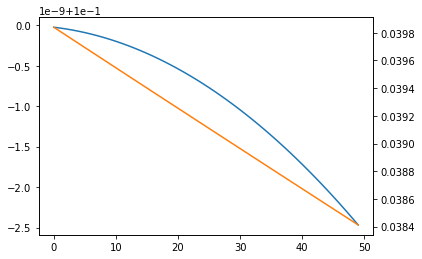

In [159]:
## import matplotlib.pyplot as plt

a = np.linspace(0.001, 0.01, )


b = lr_lambda(a)
c = deriv(a)

plt.plot(b)
plt.twinx()
plt.plot(c, color="C1")
plt.show()

## training

In [160]:
acc_func = CategoricalAccuracy()

for epoch in tqdm.tqdm_notebook(range(nb_epoch)):
    start_time = time.time()
    print("")
    
    acc_func.reset()

    m1.train()

    for i, (X, y) in enumerate(training_loader):        
        # Transfer to GPU
        X = X.cuda()
        y = y.cuda()
        
        # predict
        logits = m1(X)

        weak_loss = criterion_bce(logits, y)

        total_loss = weak_loss

        # calc metrics
#         y_pred = torch.log_softmax(logits, dim=1)
        _, y_pred = torch.max(logits, 1)
        acc = acc_func(y_pred, y)

        # ======== back propagation ========
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # ======== history ========
        print("Epoch {}, {:d}% \t ce: {:.4f} - acc: {:.4f} - took: {:.2f}s".format(
            epoch+1,
            int(100 * (i+1) / nb_batch),
            total_loss.item(),
            acc,
            time.time() - start_time
        ),end="\r")

    # using tensorboard to monitor loss and acc
    tensorboard.add_scalar('train/ce', total_loss.item(), epoch)
    tensorboard.add_scalar("train/acc", 100. * acc, epoch )

    # Validation
    with torch.set_grad_enabled(False):
        # reset metrics
        acc_func.reset()
        m1.eval()

        for X_val, y_val in val_loader:
            # Transfer to GPU
            X_val = X_val.cuda()
            y_val = y_val.cuda()


#             y_weak_val_pred, _ = model(X_val)
            logits = m1(X_val)

            # calc loss
            weak_loss_val = criterion_bce(logits, y_val)

            # metrics
#             y_val_pred =torch.log_softmax(logits, dim=1)
            _, y_val_pred = torch.max(logits, 1)
            acc_val = acc_func(y_val_pred, y_val)

            #Print statistics
            print("Epoch {}, {:d}% \t ce: {:.4f} - acc: {:.4f} - ce val: {:.4f} - acc val: {:.4f} - took: {:.2f}s".format(
                epoch+1,
                int(100 * (i+1) / nb_batch),
                total_loss.item(),
                acc,
                weak_loss_val.item(),
                acc_val,
                time.time() - start_time
            ),end="\r")

        # using tensorboard to monitor loss and acc
        tensorboard.add_scalar('validation/ce', weak_loss_val.item(), epoch)
        tensorboard.add_scalar("validation/acc", 100. * acc_val, epoch )

    for callback in callbacks:
        callback.step()


Epoch 1, 100% 	 ce: 1.5193 - acc: 0.2733 - ce val: 1.3191 - acc val: 0.4424 - took: 12.69s
Epoch 2, 100% 	 ce: 1.1120 - acc: 0.4637 - ce val: 1.2900 - acc val: 0.6241 - took: 11.84s
Epoch 3, 100% 	 ce: 1.1362 - acc: 0.5613 - ce val: 0.9302 - acc val: 0.6879 - took: 11.58s
Epoch 4, 100% 	 ce: 0.8250 - acc: 0.6370 - ce val: 0.3020 - acc val: 0.7290 - took: 12.06s
Epoch 5, 100% 	 ce: 0.7872 - acc: 0.6909 - ce val: 0.4887 - acc val: 0.7234 - took: 12.10s
Epoch 6, 100% 	 ce: 1.1325 - acc: 0.7400 - ce val: 1.4028 - acc val: 0.7025 - took: 12.20s
Epoch 7, 100% 	 ce: 1.3197 - acc: 0.7571 - ce val: 1.2463 - acc val: 0.6906 - took: 12.12s
Epoch 8, 100% 	 ce: 0.3897 - acc: 0.7853 - ce val: 0.4780 - acc val: 0.7580 - took: 12.26s
Epoch 9, 100% 	 ce: 0.4331 - acc: 0.8011 - ce val: 3.2546 - acc val: 0.7129 - took: 12.47s
Epoch 10, 100% 	 ce: 0.7080 - acc: 0.8194 - ce val: 0.4401 - acc val: 0.7536 - took: 11.76s
Epoch 11, 100% 	 ce: 1.0176 - acc: 0.8350 - ce val: 0.1817 - acc val: 0.7656 - took: 12.

In [ ]:
# ♫♪.ılılıll|̲̅̅●̲̅̅|̲̅̅=̲̅̅|̲̅̅●̲̅̅|llılılı.♫♪